<a href="https://colab.research.google.com/github/rheazh/Data-Analysis/blob/main/Unit6_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resting Blood Pressure in correlation to Max HR, Cholesterol, and Age

I was originally going to be predicting severity of heart disease based on Max HR, Cholesterol and Age but it would have been a little more difficult so I changed it to Resting blood pressure for convience of using the same data set.

In [1]:
!pip install ucimlrepo

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

In [3]:
from ucimlrepo import fetch_ucirepo

# Fetch the heart disease dataset
heart_disease = fetch_ucirepo(id=45)

# Extract features (using the 'name' column) and target variable
feature_names = heart_disease.variables[heart_disease.variables['role'] == 'Feature']['name'].tolist()
target_name = heart_disease.variables[heart_disease.variables['role'] == 'Target']['name'].iloc[0]

# Combine features and target into a single DataFrame
X = heart_disease.data.features
y = heart_disease.data.targets

# Convert the feature data into a pandas DataFrame with the correct column names
heart_df = pd.DataFrame(X, columns=feature_names)

# Add the target column
heart_df[target_name] = y

# Rename columns for readability
heart_df.columns = ['Age', 'Sex', 'Chest Pain', 'RestBP', 'Cholesterol', 'Fasting Blood Sugar',
                    'Resting Electrocardiographic Results', 'MaxHR', 'Angina', 'Oldpeak', 'Slope',
                    'Number of Major Vessels', 'Thalassemia', 'HeartD']

# Save the DataFrame to a CSV file
heart_df.to_csv('heart_disease_dataset.csv', index=False)

# Display the first few rows of the DataFrame to check the result
heart_df


,Age,Sex,Chest Pain,RestBP,Cholesterol,Fasting Blood Sugar,Resting Electrocardiographic Results,MaxHR,Angina,Oldpeak,Slope,Number of Major Vessels,Thalassemia,HeartD
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


In [4]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.2 MB/s eta 0:00:00


In [5]:
import bambi as bmb

# Define the models with triple combinations of predictors
model_rbp_bmb_1 = bmb.Model("RestBP ~ Age + Cholesterol + MaxHR", heart_df, family="gaussian")
model_rbp_bmb_2 = bmb.Model("RestBP ~ Cholesterol + MaxHR + Oldpeak", heart_df, family="gaussian")

# Fit the models and store the posterior samples
idata_rbp_bmb_1 = model_rbp_bmb_1.fit(idata_kwargs={"log_likelihood": True})
idata_rbp_bmb_2 = model_rbp_bmb_2.fit(idata_kwargs={"log_likelihood": True})

Output()

Output()

Output()

Output()

I created two models to predict resting blood pressure (RestBP) using different sets of factors. The first model looks at age, cholesterol, and max heart rate, while the second one uses cholesterol, max heart rate, and oldpeak. Both models use a Bayesian approach to make predictions and learn from the data, helping me figure out which combination of factors is the most accurate for predicting blood pressure.

In [22]:
import arviz as az

# Compare models
cmp_df = az.compare(
    {"Model 1 (Age + Chol + MaxHR)": idata_rbp_bmb_1,
     "Model 2 (Age + Chol + Oldpeak)": idata_rbp_bmb_2},
    ic="loo"  # Use "waic" for WAIC if desired
)

# Show the comparison dataframe
print(cmp_df)

                                rank     elpd_loo     p_loo  elpd_diff  \
Model 1 (Age + Chol + MaxHR)       0 -1289.087593  5.246981   0.000000   
Model 2 (Age + Chol + Oldpeak)     1 -1295.955729  5.693963   6.868136   

                                 weight         se       dse  warning scale  
Model 1 (Age + Chol + MaxHR)    0.72839  14.957848  0.000000    False   log  
Model 2 (Age + Chol + Oldpeak)  0.27161  14.330583  5.974736    False   log  


I compared the models and it seems that the first one (Age, Cholesterol, and MaxHR) is better for predicting resting blood pressure.

In [6]:
with pm.Model() as model_mhd:

    # Priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)  # Intercept
    β0 = pm.Normal("β0", mu=0, sigma=10)  # Coefficient for Age
    β1 = pm.Normal("β1", mu=0, sigma=10)  # Coefficient for Max Heart Rate
    β2 = pm.Normal("β2", mu=0, sigma=10)  # Coefficient for Cholesterol

    # Linear part of the model (predictor equation)
    μ = α + β0 * heart_df.Age + β1 * heart_df.MaxHR + β2 * heart_df.Cholesterol

    # Prior for the standard deviation (dispersion)
    σ = pm.HalfNormal("σ", sigma=10)

    # Likelihood (Normal distribution for resting blood pressure)
    y_pred = pm.Normal("y", mu=μ, sigma=σ, observed=heart_df.RestBP)

    # Sample from the posterior
    idata_mhd = pm.sample(idata_kwargs={"log_likelihood": True})

Output()

Output()

In [7]:
pm.sample_posterior_predictive(idata_mhd, model = model_mhd, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [8]:
with pm.Model() as model_nbh:

    # Priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)  # Intercept
    β0 = pm.Normal("β0", mu=0, sigma=10)  # Coefficient for Age
    β1 = pm.Normal("β1", mu=0, sigma=10)  # Coefficient for Max Heart Rate
    β2 = pm.Normal("β2", mu=0, sigma=10)  # Coefficient for Cholesterol

    # Linear part of the model (predictor equation)
    μ = pm.math.exp(α + β0 * heart_df.Age + β1 * heart_df.MaxHR + β2 * heart_df.RestBP)

    # Prior for the standard deviation (dispersion)
    σ = pm.HalfNormal("σ", sigma=10)

    # Likelihood (Negative Binomial distribution for cholesterol)
    y_pred = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=heart_df.Cholesterol)

    # Sample from the posterior
    idata_nbh = pm.sample(idata_kwargs={"log_likelihood": True})

Output()

Output()

In [9]:
pm.sample_posterior_predictive(idata_nbh, model = model_nbh, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

I’m comparing the two models to evaluate how different distributions affect the predictions. The first model uses a Normal distribution to predict RestBP, assuming constant variance and a typical linear relationship. The second model uses a Negative Binomial distribution for Cholesterol, which is more appropriate if the data is overdispersed or count-like. By comparing these models, I can assess which distribution better captures the underlying characteristics of the data and provides more accurate predictions.

In [10]:
#cmp_df stands for compare dataframe
cmp_df = az.compare( {"normal":idata_mhd,"negative binomial":idata_nbh} )

#0 is the best rank; we want a lower elpd_loo
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
normal,0,-1314.24486,4.759073,0.00000,0.993425,14.39188,0.000000,False,log
negative binomial,1,-1608.65122,5.317695,294.40636,0.006575,15.64587,19.025137,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

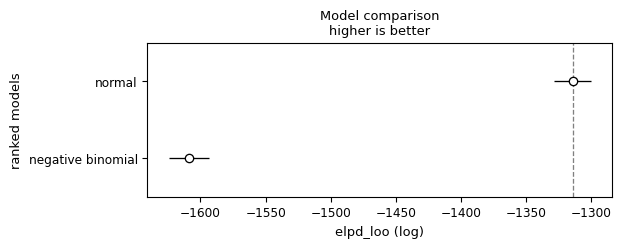

In [ ]:
az.plot_compare(cmp_df)

After comparing, it seems like the normal model is better. Since the Normal model performed better, it suggests that RestBP follows a distribution with constant variance and that a simpler linear approach is more appropriate for this specific data.

In [13]:
with pm.Model() as model_ghd:

    # Priors for the linear part of the model (same as before)
    α = pm.Normal("α", mu=0, sigma=1)  # Intercept
    β0 = pm.Normal("β0", mu=0, sigma=10)  # Coefficient for Age
    β1 = pm.Normal("β1", mu=0, sigma=10)  # Coefficient for Max Heart Rate
    β2 = pm.Normal("β2", mu=0, sigma=10)  # Coefficient for Cholesterol

    # Linear predictor (log of the mean of RestBP)
    μ = α + β0 * heart_df.Age + β1 * heart_df.MaxHR + β2 * heart_df.Cholesterol

    # Prior for the dispersion parameter (inverse scale of the Gamma distribution)
    τ = pm.HalfNormal("τ", sigma=10)

    # Likelihood (Gamma distribution with a log link)
    y_pred = pm.Gamma("y", mu=pm.math.exp(μ), sigma=τ, observed=heart_df.RestBP)

    # Sample from the posterior
    idata_ghd = pm.sample(idata_kwargs={"log_likelihood": True})

Output()

Output()

In [14]:
pm.sample_posterior_predictive(idata_ghd, model = model_ghd, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

I decided to compare the normal distribution with a gamma just to test if there could possibly be a better suited option.

In [15]:
#cmp_df stands for compare dataframe
comp_df = az.compare( {"normal":idata_mhd,"gamma":idata_ghd} )

#0 is the best rank; we want a lower elpd_loo
comp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
gamma,0,-1284.456275,5.415654,0.000000,1.000000e+00,14.030193,0.000000,False,log
normal,1,-1314.244860,4.759073,29.788585,3.254286e-12,14.391880,7.031409,False,log


Since the Gamma model worked better, it suggests that the data is skewed or has a few really high values, which the Normal model couldn’t capture as well. The Gamma model is a better fit for this kind of data, so it helps provide more accurate predictions and a clearer understanding of the relationship between the variables.

In [11]:
!pip install bambi

In [12]:
import bambi as bmb

In [18]:
# Define the model with Bambi
model = bmb.Model("RestBP ~ Cholesterol + Age + MaxHR", data=heart_df, family="gamma", link="log")

# Fit the model
idata = model.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [19]:
model

       Formula: RestBP ~ Cholesterol + Age + MaxHR
        Family: gamma
          Link: mu = log
  Observations: 303
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 25.383)
            Cholesterol ~ Normal(mu: 0.0, sigma: 0.0484)
            Age ~ Normal(mu: 0.0, sigma: 0.277)
            MaxHR ~ Normal(mu: 0.0, sigma: 0.1095)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

I’m plotting the posterior distributions for **Cholesterol**, **Age**, and **MaxHR** to visualize how each predictor affects **Resting Blood Pressure** (RestBP) in my model. By doing this, I can see the strength and uncertainty of each predictor's effect, which helps me understand which variables are most influential in predicting RestBP. These plots allow me to assess the relationships between predictors and RestBP in a clear way, making it easier to interpret the model’s results and inform further analysis.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


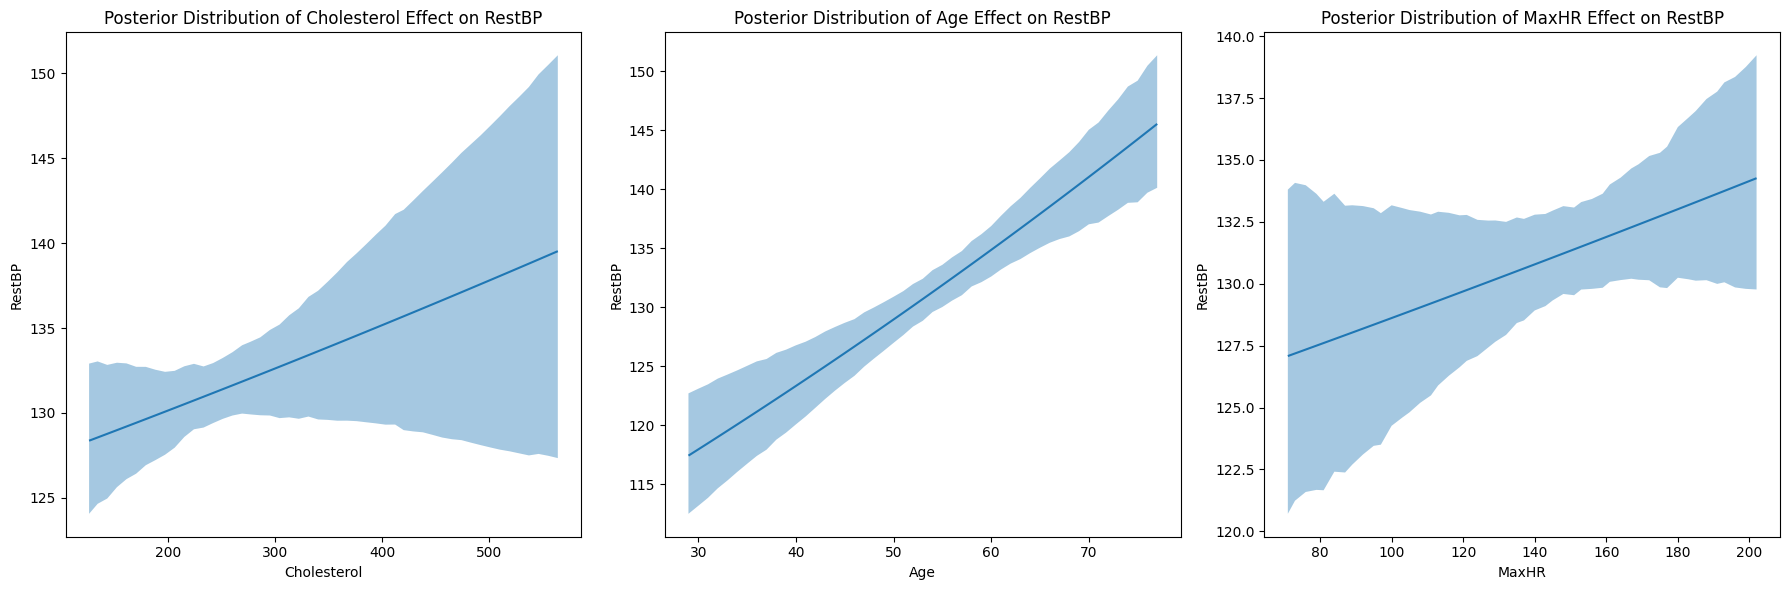

In [20]:
import matplotlib.pyplot as plt

# Plot the posterior distributions for each predictor
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Cholesterol
bmb.interpret.plot_predictions(
    model,
    idata,
    ["Cholesterol"],  # Visualize the effect of Cholesterol
    ax=axs[0]
)
axs[0].set_title("Posterior Distribution of Cholesterol Effect on RestBP")

# Plot for Age
bmb.interpret.plot_predictions(
    model,
    idata,
    ["Age"],  # Visualize the effect of Age
    ax=axs[1]
)
axs[1].set_title("Posterior Distribution of Age Effect on RestBP")

# Plot for MaxHR
bmb.interpret.plot_predictions(
    model,
    idata,
    ["MaxHR"],  # Visualize the effect of MaxHR
    ax=axs[2]
)
axs[2].set_title("Posterior Distribution of MaxHR Effect on RestBP")

# Adjust layout
plt.tight_layout()
plt.show()


The hourglass shape in the plots suggests that Resting Blood Pressure (RestBP)is more sensitive to extreme values of the predictors (Cholesterol, Age, and MaxHR) than to moderate values. For instance, both very low and very high cholesterol levels, as well as Max heart rate levels, show a stronger effect on blood pressure, while middle values have less impact. This pattern indicates that RestBP changes more dramatically at the extremes, possibly due to underlying biological factors, while it remains more stable for individuals in the middle ranges of these predictors.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


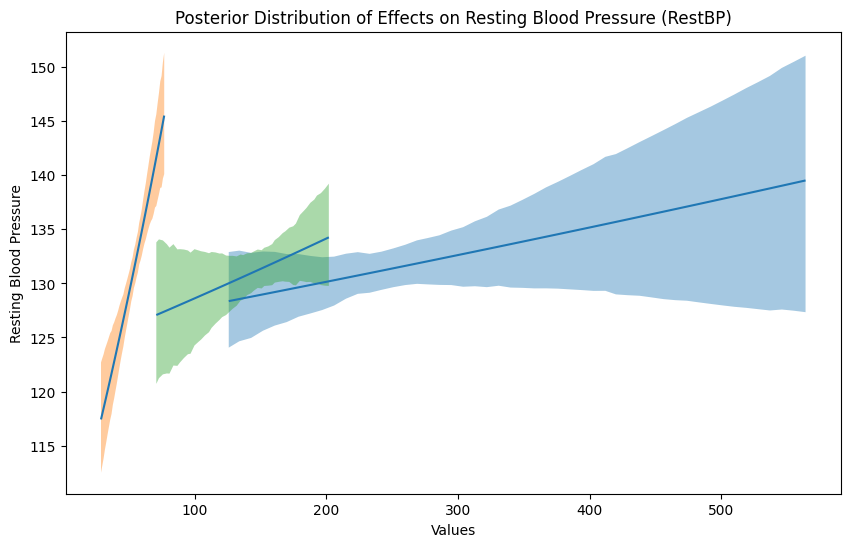

In [21]:
import matplotlib.pyplot as plt

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Cholesterol
bmb.interpret.plot_predictions(
    model,
    idata,
    ["Cholesterol"],  # Visualize the effect of Cholesterol
    ax=ax,
)

# Plot for Age
bmb.interpret.plot_predictions(
    model,
    idata,
    ["Age"],  # Visualize the effect of Age
    ax=ax,
)

# Plot for MaxHR
bmb.interpret.plot_predictions(
    model,
    idata,
    ["MaxHR"],  # Visualize the effect of MaxHR
    ax=ax,
)

# Set title and labels for the plot
ax.set_title("Posterior Distribution of Effects on Resting Blood Pressure (RestBP)")
ax.set_xlabel("Values")
ax.set_ylabel("Resting Blood Pressure")

# Show the final overlaid plot
plt.show()


I put the graphs together and this is what I ended up with. I thought that the cholesterol levels were going way too high.
Even total cholesterol levels around 240 are considered high so I thought that there must have been some sort of mistake as they were going above 500. I looked through my data set and found only a few values that reached 300 and above. These values are probably due to uncommon conditions such as hypercholesterolemia where the cholesterol levels can reach up to 500. I decided to remove levels above 300 and run my model again.

In [27]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Fetch the heart disease dataset
heart_disease = fetch_ucirepo(id=45)

# Extract features (using the 'name' column) and target variable
feature_names = heart_disease.variables[heart_disease.variables['role'] == 'Feature']['name'].tolist()
target_name = heart_disease.variables[heart_disease.variables['role'] == 'Target']['name'].iloc[0]

# Combine features and target into a single DataFrame
X = heart_disease.data.features
y = heart_disease.data.targets

# Convert the feature data into a pandas DataFrame with the correct column names
heart_df = pd.DataFrame(X, columns=feature_names)

# Add the target column
heart_df[target_name] = y

# Rename columns for readability
heart_df.columns = ['Age', 'Sex', 'Chest Pain', 'RestBP', 'Cholesterol', 'Fasting Blood Sugar',
                    'Resting Electrocardiographic Results', 'MaxHR', 'Angina', 'Oldpeak', 'Slope',
                    'Number of Major Vessels', 'Thalassemia', 'HeartD']

# Remove rows where Cholesterol > 300
heart_df_filtered = heart_df[heart_df['Cholesterol'] <= 300]

#save the filtered dataset to a new CSV file
heart_df_filtered.to_csv('heart_disease_filtered.csv', index=False)
heart_df_filtered


,Age,Sex,Chest Pain,RestBP,Cholesterol,Fasting Blood Sugar,Resting Electrocardiographic Results,MaxHR,Angina,Oldpeak,Slope,Number of Major Vessels,Thalassemia,HeartD
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


Since I removed outliers I thought that a normal distribution may work better than the gamma for my filtered data set so I decided to compare the two models again just in case.

In [38]:
with pm.Model() as model_ghd2:

    # Priors for the linear part of the model (same as before)
    α = pm.Normal("α", mu=0, sigma=1)  # Intercept
    β0 = pm.Normal("β0", mu=0, sigma=10)  # Coefficient for Age
    β1 = pm.Normal("β1", mu=0, sigma=10)  # Coefficient for Max Heart Rate
    β2 = pm.Normal("β2", mu=0, sigma=10)  # Coefficient for Cholesterol

    # Linear predictor (log of the mean of RestBP)
    μ = α + β0 * heart_df_filtered.Age + β1 * heart_df_filtered.MaxHR + β2 * heart_df_filtered.Cholesterol

    # Prior for the dispersion parameter
    τ = pm.HalfNormal("τ", sigma=10)

    # Likelihood
    y_pred = pm.Gamma("y", mu=pm.math.exp(μ), sigma=τ, observed=heart_df_filtered.RestBP)

    # Sample from the posterior
    idata_ghd2 = pm.sample(idata_kwargs={"log_likelihood": True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [39]:
pm.sample_posterior_predictive(idata_ghd2, model = model_ghd2, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [42]:
with pm.Model() as model_mhd2:

    # Priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)  # Intercept
    β0 = pm.Normal("β0", mu=0, sigma=10)  # Coefficient for Age
    β1 = pm.Normal("β1", mu=0, sigma=10)  # Coefficient for Max Heart Rate
    β2 = pm.Normal("β2", mu=0, sigma=10)  # Coefficient for Cholesterol

    # Linear part of the model
    μ = α + β0 * heart_df_filtered.Age + β1 * heart_df_filtered.MaxHR + β2 * heart_df_filtered.Cholesterol

    # Prior for the standard deviation
    σ = pm.HalfNormal("σ", sigma=10)

    # Likelihood (Normal distribution for resting blood pressure)
    y_pred = pm.Normal("y", mu=μ, sigma=σ, observed=heart_df_filtered.RestBP)

    # Sample from the posterior
    idata_mhd2 = pm.sample(idata_kwargs={"log_likelihood": True})

Output()

Output()

In [43]:
pm.sample_posterior_predictive(idata_mhd2, model = model_mhd2, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [45]:
#cmp_df stands for compare dataframe
cmp_df2 = az.compare( {"normal":idata_mhd2,"gamma":idata_ghd2} )

#0 is the best rank; we want a lower elpd_loo
cmp_df2

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
normal,0,-1112.227255,4.197226,0.000000,1.000000e+00,12.858159,0.000000,False,log
gamma,1,-2559.921880,1290.159657,1447.694625,7.878498e-11,6.591678,12.774845,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

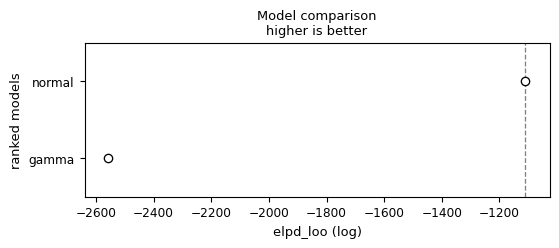

In [46]:
az.plot_compare(cmp_df2)

By removing cholesterol values above 300, the data became more balanced and less skewed, which is what I am assuming is making a normal distribution a better fit. This tells me that for most people, cholesterol levels are more evenly spread around the average, which lies around lower-mid 200s, without extreme values affecting the results. this suggests that for the typical range of cholesterol, the relationship with blood pressure follows a more standard pattern. The normal distribution now works better because it matches the data more closely.

In [48]:
# Define the model with Bambi
model2 = bmb.Model("RestBP ~ Cholesterol + Age + MaxHR", data=heart_df_filtered, family="gaussian", link="log")

# Fit the model
idata2 = model.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


I am going to replot the individual graphs just to see what the data set filtering and model change has done to the relationships between mainly cholesterol and resting BP.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


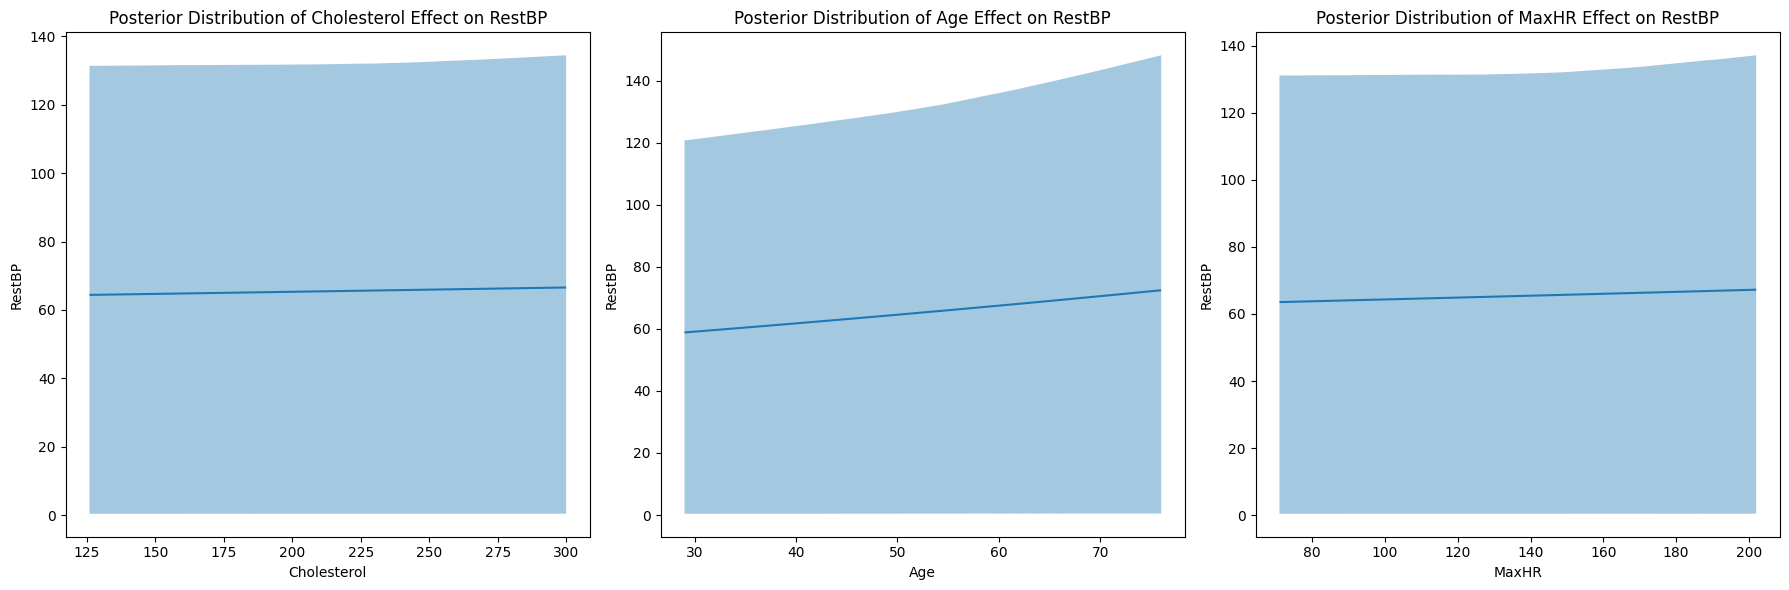

In [51]:
import matplotlib.pyplot as plt

# Plot the posterior distributions for each predictor
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Cholesterol
bmb.interpret.plot_predictions(
    model2,
    idata2,
    ["Cholesterol"],  # Visualize the effect of Cholesterol
    ax=axs[0]
)
axs[0].set_title("Posterior Distribution of Cholesterol Effect on RestBP")

# Plot for Age
bmb.interpret.plot_predictions(
    model2,
    idata2,
    ["Age"],  # Visualize the effect of Age
    ax=axs[1]
)
axs[1].set_title("Posterior Distribution of Age Effect on RestBP")

# Plot for MaxHR
bmb.interpret.plot_predictions(
    model2,
    idata2,
    ["MaxHR"],  # Visualize the effect of MaxHR
    ax=axs[2]
)
axs[2].set_title("Posterior Distribution of MaxHR Effect on RestBP")

# Adjust layout
plt.tight_layout()
plt.show()


I have no idea what happened here or why it looks like that. These values are definetly not correct because no living persons blood pressure should ever be reaching 0. A blood pressure of zero would mean that there is no blood flow in the body. This would occur if the heart stops beating or if there is a complete failure of the circulatory system, which means the blood is not being pumped through the arteries at all.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


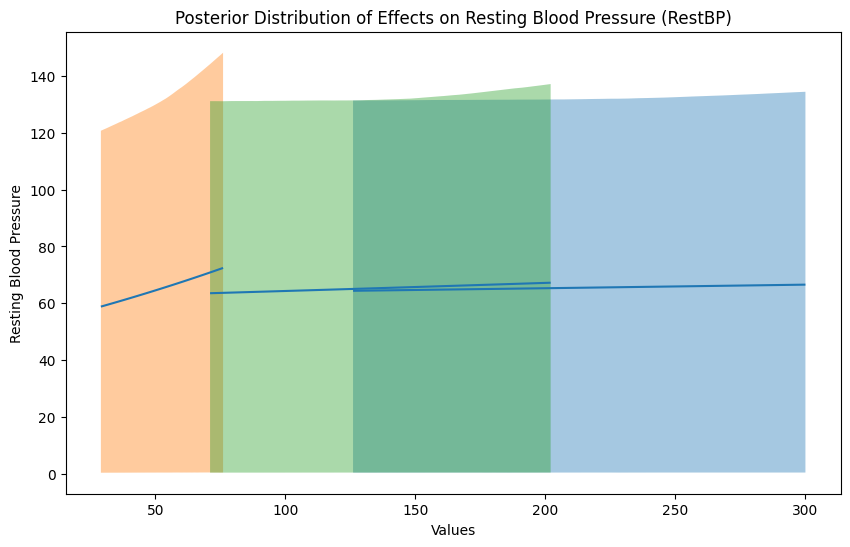

In [50]:
import matplotlib.pyplot as plt

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Cholesterol
bmb.interpret.plot_predictions(
    model2,
    idata2,
    ["Cholesterol"],  # Visualize the effect of Cholesterol
    ax=ax,
)

# Plot for Age
bmb.interpret.plot_predictions(
    model2,
    idata2,
    ["Age"],  # Visualize the effect of Age
    ax=ax,
)

# Plot for MaxHR
bmb.interpret.plot_predictions(
    model2,
    idata2,
    ["MaxHR"],  # Visualize the effect of MaxHR
    ax=ax,
)

# Set title and labels for the plot
ax.set_title("Posterior Distribution of Effects on Resting Blood Pressure (RestBP)")
ax.set_xlabel("Values")
ax.set_ylabel("Resting Blood Pressure")

# Show the final overlaid plot
plt.show()


This is what the plot looks like after I put them all together. I'm gonna guess that it is because after I removed the outliers from the data set, the cholesterol values became more centered, causing predictions to cluster around the mean and possibly leading to these incorrect predicitons.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


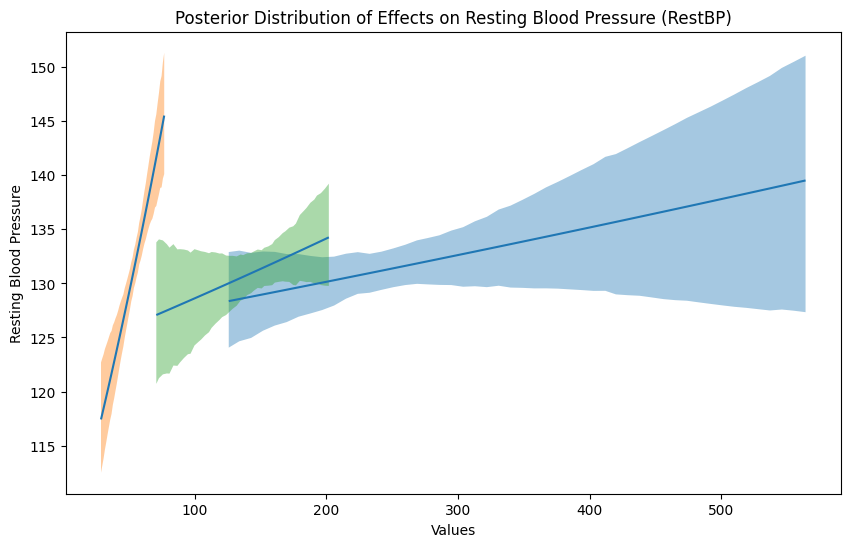

In [52]:
import matplotlib.pyplot as plt

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Cholesterol
bmb.interpret.plot_predictions(
    model,
    idata,
    ["Cholesterol"],  # Visualize the effect of Cholesterol
    ax=ax,
)

# Plot for Age
bmb.interpret.plot_predictions(
    model,
    idata,
    ["Age"],  # Visualize the effect of Age
    ax=ax,
)

# Plot for MaxHR
bmb.interpret.plot_predictions(
    model,
    idata,
    ["MaxHR"],  # Visualize the effect of MaxHR
    ax=ax,
)

# Set title and labels for the plot
ax.set_title("Posterior Distribution of Effects on Resting Blood Pressure (RestBP)")
ax.set_xlabel("Values")
ax.set_ylabel("Resting Blood Pressure")

# Show the final overlaid plot
plt.show()


I decided just to stick with my original plot. The plot shows that as the values of Age, MaxHR, and Cholesterol increase, resting blood pressure (RestBP) also tends to increase, which is expected based on the relationship between these predictors and RestBP. However, the shape of the predictions is not consistent across the entire range of predictor values. In the middle range of each predictor, the model is more confident about the relationship, resulting in narrower prediction intervals. But as the predictor values continue to increase, the model becomes less certain, which is reflected in the widening of the prediction intervals at the extreme values. This suggests that while there is a clear trend of increasing RestBP with these predictors, there is more variability and uncertainty at the higher ends of the predictor ranges.